# **第6章: 機械学習**

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

### **50. データの入手・整形**

[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．



1.   ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2.   情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．

1.   抽出された事例をランダムに並び替える．
2.   抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
#ファイルのダウンロード、解凍
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip ./NewsAggregatorDataset.zip

--2022-12-22 07:43:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  26.4MB/s    in 1.1s    

2022-12-22 07:43:27 (26.4 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

#ファイルを読み込む
df = pd.read_csv("newsCorpora.csv", sep="\t", header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

#各カラムのデータ数、欠損値、オブジェクトを確認する
df.info()

#情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する
df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]
df = df[["TITLE", "CATEGORY"]]

#学習、検証、評価データに分割する
train_full, test = train_test_split(df, test_size=0.1, shuffle=True)
train, valid = train_test_split(train_full, test_size=0.1, shuffle=True)

#学習、検証、評価データをファイルに保存する
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

print("\n【CATEGORYの事例数】")
print("train\n", "-"*50,"\n", train["CATEGORY"].value_counts())
print()
print("valid\n", "-"*50,"\n", valid["CATEGORY"].value_counts())
print()
print("test\n", "-"*50,"\n", test["CATEGORY"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB

【CATEGORYの事例数】
train
 -------------------------------------------------- 
 b    4558
e    4296
t    1223
m     728
Name: CATEGORY, dtype: int64

valid
 -------------------------------------------------- 
 b    507
e    474
t    127
m     93
Name: CATEGORY, dtype: int64

test
 -------------------------------------------------- 
 b    562
e    509
t    174
m     89
Name: CATEGORY, dtype: int64


### **51. 特徴量抽出**

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#前処理（関数）
def preprocessing(text):
  text = "".join([i for i in text if i not in string.punctuation])
  text = text.lower()
  text = re.sub("[0-9]+", "", text)
  return text

#データの連結、前処理を行う
df = pd.concat([train, valid, test], axis=0)
df["TITLE"] = df["TITLE"].map(lambda x: preprocessing(x))

# 単語ベクトル化、DataFrameに変換する
vec_tfidf = TfidfVectorizer()
data = vec_tfidf.fit_transform(df["TITLE"])
data = pd.DataFrame(data.toarray(), columns=vec_tfidf.get_feature_names())

# dataを3分割する（ラベルも同時に分割させるため、train_test_splitは使用しない）
split_point_1 = int(len(data) // 3)
split_point_2 = int(split_point_1 * 2)

#学習、検証、評価データ
x_train = data[:split_point_1]
x_valid = data[split_point_1:split_point_2]
x_test = data[split_point_2:]

#学習、検証、評価ラベル
y_data = df["CATEGORY"]
y_train = y_data[:split_point_1]
y_valid = y_data[split_point_1:split_point_2]
y_test = y_data[split_point_2:]


# 特徴量をファイルに保存する
x_train.to_csv('train.feature.txt', sep='\t', index=False)
x_valid.to_csv('valid.feature.txt', sep='\t', index=False)
x_test.to_csv('test.feature.txt', sep='\t', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### **52. 学習**

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．



In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

### **53. 予測**

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．



In [ ]:
print(f"カテゴリ順：{model.classes_}\n")

Y_pred = model.predict(x_valid)
print(f"各記事のカテゴリ（ラベル）：{y_valid.values}")
print(f"各記事のカテゴリ予測：{Y_pred}\n")

Y_pred = model.predict_proba(x_valid)
print(f"カテゴリの予測確率：\n{Y_pred}")

カテゴリ順：['b' 'e' 'm' 't']

各記事のカテゴリ（ラベル）：['e' 'b' 'b' ... 'b' 'b' 'e']
各記事のカテゴリ予測：['e' 'e' 'b' ... 'b' 'b' 'e']

カテゴリの予測確率：
[[0.22032916 0.65338683 0.05658664 0.06969737]
 [0.3348031  0.53359423 0.0536991  0.07790357]
 [0.60546317 0.08692622 0.0537283  0.25388231]
 ...
 [0.67138052 0.20411088 0.04925028 0.07525832]
 [0.83508653 0.04852853 0.0308403  0.08554464]
 [0.19597896 0.65678776 0.04674937 0.10048391]]


### **54. 正解率の計測**

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．



In [ ]:
from sklearn.metrics import accuracy_score

Y_pred_train = model.predict(x_train)
Y_pred_test = model.predict(x_test)

print(f"train_accuracy：{accuracy_score(y_train, Y_pred_train)}")
print(f"test_accuracy：{accuracy_score(y_test, Y_pred_test)}")

train_accuracy：0.9248762932973459
test_accuracy：0.8289118705035972


### **55. 混同行列の作成**

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [ ]:
from sklearn.metrics import confusion_matrix

print(f"学習データの混同行列：\n{confusion_matrix(y_train, Y_pred_train)}\n")
print(f"評価データの混同行列：\n{confusion_matrix(y_test, Y_pred_test)}")

学習データの混同行列：
[[1885   16    0    3]
 [   6 1724    0    1]
 [  64   73  152    1]
 [  99   71    0  351]]

評価データの混同行列：
[[1754  109    1    8]
 [  52 1701    1    0]
 [ 110  126   73    0]
 [ 188  165    1  159]]


### **56. 適合率，再現率，F1スコアの計測**

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(y_data, y_pred, ave=None):
  precision_sco = precision_score(y_data, y_pred, average=ave)
  recall_sco = recall_score(y_data, y_pred, average=ave)
  f1_sco = f1_score(y_data, y_pred, average=ave)
  form = "適合率：{}\n再現率：{}\nF１：{}\n".format(precision_sco, recall_sco, f1_sco)
  return form

print(f"【カテゴリ順】{model.classes_}\n\n{metrics(y_test, Y_pred_test)}")
print("【マクロ平均】\n", metrics(y_test, Y_pred_test, "macro"))
print("【マイクロ平均】\n", metrics(y_test, Y_pred_test, "micro"))

【カテゴリ順】['b' 'e' 'm' 't']

適合率：[0.83365019 0.80961447 0.96052632 0.95209581]
再現率：[0.93696581 0.96978335 0.23624595 0.30994152]
F１：[0.88229376 0.88249027 0.37922078 0.46764706]

【マクロ平均】
 適合率：0.8889716958967772
再現率：0.6132341598659298
F１：0.6529129682483256

【マイクロ平均】
 適合率：0.8289118705035972
再現率：0.8289118705035972
F１：0.8289118705035972



### **57. 特徴量の重みの確認**

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．


In [ ]:
import numpy as np

features = x_train.columns.values
for c, coef in zip(model.classes_, model.coef_):
  top_10 = pd.DataFrame(features[np.argsort(-coef)[:10]], columns=[f"重みの高い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  worst_10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=[f"重みの低い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  print( top_10, "\n"),
  print(worst_10, "\n", "-"*70)

   重みの高い特徴量トップ10（クラス名：b）
1                  china
2                   bank
3                     us
4                    fed
5                 update
6                   euro
7                    ecb
8                 profit
9                billion
10               ukraine 

   重みの低い特徴量トップ10（クラス名：b）
1                    the
2                    and
3                    her
4                  ebola
5                  study
6                  apple
7                   star
8                 google
9               facebook
10            kardashian 
 ----------------------------------------------------------------------
   重みの高い特徴量トップ10（クラス名：e）
1             kardashian
2                    her
3                    kim
4                    the
5                  cyrus
6                   star
7                  miley
8                  chris
9                    and
10                    he 

   重みの低い特徴量トップ10（クラス名：e）
1                     us
2                 update
3                   say

### **58. 正則化パラメータの変更**

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．



【正則化パラメータ：0.001】

train_accuracy：0.42825011246063877
valid_accuracy：0.41632928475033737
test_accuracy：0.420863309352518

【正則化パラメータ：0.025750000000000002】

train_accuracy：0.7530364372469636
valid_accuracy：0.7235717498875394
test_accuracy：0.7149280575539568

【正則化パラメータ：0.0505】

train_accuracy：0.7777777777777778
valid_accuracy：0.7521367521367521
test_accuracy：0.7511241007194245

【正則化パラメータ：0.07525000000000001】

train_accuracy：0.7811515969410706
valid_accuracy：0.7613585245164193
test_accuracy：0.758318345323741

【正則化パラメータ：0.1】

train_accuracy：0.7838506522717049
valid_accuracy：0.7647323436797121
test_accuracy：0.7610161870503597



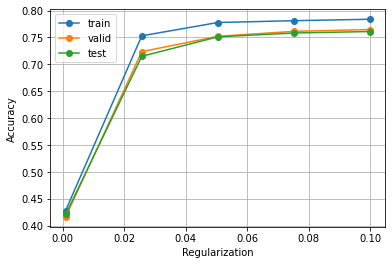

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#モデル構築、学習（関数）
def LR_model_fit(x_data, y_data, c):
  model = LogisticRegression(C=c)
  model.fit(x_data, y_data) 
  return model

#学習済みモデルを用いて予測する（関数）
def LR_pred(x_data, y_data, model):
  Y_pred_data = model.predict(x_data)
  accuracy = accuracy_score(Y_pred_data, y_data)
  return accuracy

train_acc = []
valid_acc = []
test_acc = []

#正則化パラメータ
c_list = np.linspace(0.001, 0.1, 5)

for c in c_list:
  model = LR_model_fit(x_train, y_train, c)
  pre_train = LR_pred(x_train, y_train, model)
  pre_valid = LR_pred(x_valid, y_valid, model)
  pre_test = LR_pred(x_test, y_test, model)

  train_acc.append(pre_train)
  valid_acc.append(pre_valid)
  test_acc.append(pre_test)

  print(f"【正則化パラメータ：{c}】\n")
  print(f"train_accuracy：{pre_train}")
  print(f"valid_accuracy：{pre_valid}")
  print(f"test_accuracy：{pre_test}\n")

#可視化
plt.plot(c_list, train_acc, label="train", marker="o")
plt.plot(c_list, valid_acc, label="valid", marker="o")
plt.plot(c_list, test_acc, label="test", marker="o")

plt.legend()
plt.grid(True)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.show()

### **59. ハイパーパラメータの探索**

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．



In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"C": [0.001, 0.005, 10]}

# グリッドサーチを行う
gs_model = GridSearchCV(LogisticRegression(max_iter=1500),params, cv=5, verbose=1)
gs_model.fit(x_train, y_train)

#最適なモデルを取得する
best_gs_model = gs_model.best_estimator_
print("\ntrain_score: {:.2%}".format(best_gs_model.score(x_train, y_train)))
print("valid_score: {:.2%}".format(best_gs_model.score(x_valid, y_valid)))
print("test_score: {:.2%}".format(best_gs_model.score(x_test, y_test)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits

train_score: 99.93%
valid_score: 87.45%
test_score: 87.28%
